In [1]:
# import imageio as iio
# import numpy as np
# import matplotlib.pyplot as plt

# plt.imshow(iio.imread("rPPG_BVP.png"))
# plt.show()
# plt.imshow(iio.imread("rPPG_BVP_PSD.png"))
# plt.show()

In [2]:
# autorelead libraries
%load_ext autoreload
%autoreload 2

In [3]:
import os
import time
import random
import pickle
import argparse

import numpy as np
import scipy.sparse as sp
import scipy.signal as sig
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader

from config import get_config
from dataset import data_loader
from neural_methods.model.ContrastFusion import ContrastFusion

In [4]:
def calcMetrics(input_data, sampFreq, B, window_size=None, use_harmonic=False, normalize=False):
    # define goodness parameters
    B1 = 0.75 # low cutoff
    B2 = 3 # high cutoff

    if window_size is None:
        pulseCalcLength = len(input_data)
    else:
        pulseCalcLength = np.uint32(window_size/(1.0/sampFreq))
    pulseRate_result = np.empty(len(input_data)-pulseCalcLength + 1)
    goodnessMetric_result = np.empty(len(input_data)-pulseCalcLength + 1)

    for i in range(0, len(pulseRate_result)):
        window = input_data[i:i+pulseCalcLength]
        # ppgFreq, ppgPower = sig.periodogram(window, fs=sampFreq, nfft=180000)
        ppgFreq, ppgPower = sig.welch(x=window, nperseg=len(window)//3, fs=sampFreq, nfft=180000)
        maskFreq = (ppgFreq > B1)&(ppgFreq<B2)
        # ppgFreq = ppgFreq[maskFreq]
        ppgPower = ppgPower * maskFreq
        if use_harmonic:
            # harmonic PSD
            harmonicppgPower = ppgPower[::2]
            harmonicppgPower = np.pad(harmonicppgPower, (0, len(ppgPower) - len(harmonicppgPower)))
            # find peak frequency
            peakFreq = ppgFreq[np.argmax(ppgPower + harmonicppgPower)]
        else:
            peakFreq = ppgFreq[np.argmax(ppgPower)]
        pulseRate = 60.0*peakFreq
        pulseRate_result[i] = pulseRate
        # compute goodness
        aroundPulseRate = (ppgFreq > peakFreq - B) & (ppgFreq < peakFreq + B)
        withinBandpass = (ppgFreq >= B1) & (ppgFreq <= B2)
        powerPulseRate = np.sum(ppgPower[aroundPulseRate])
        powerAll = np.sum(ppgPower[withinBandpass])
        if normalize:
            goodnessMetric_result[i] = powerPulseRate / powerAll
        else:
            goodnessMetric_result[i] = powerPulseRate / (powerAll - powerPulseRate)
    timestamps = np.arange(len(pulseRate_result))
    return timestamps, goodnessMetric_result, pulseRate_result

def custom_detrend(sig, Lambda):
    """custom_detrend(sig, Lambda) -> filtered_signal
    This function applies a detrending filter.
    This code is based on the following article "An advanced detrending method with application
    to HRV analysis". Tarvainen et al., IEEE Trans on Biomedical Engineering, 2002.
    *Parameters*
      ``sig`` (1d numpy array):
        The sig where you want to remove the trend.
      ``Lambda`` (int):
        The smoothing parameter.
    *Returns*
      ``filtered_signal`` (1d numpy array):
        The detrended sig.
    """
    signal_length = sig.shape[0]

    # observation matrix
    H = np.identity(signal_length)

    # second-order difference matrix

    ones = np.ones(signal_length)
    minus_twos = -2 * np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = sp.spdiags(diags_data, diags_index, (signal_length - 2), signal_length).toarray()
    filtered_signal = np.dot((H - np.linalg.inv(H + (Lambda ** 2) * np.dot(D.T, D))), sig)
    return filtered_signal

def pulse_rate_from_power_spectral_density(pleth_sig: np.array, FS: float,
                                           LL_PR: float, UL_PR: float,
                                           BUTTER_ORDER: int = 6,
                                           DETREND: bool = False,
                                           FResBPM: float = 0.1,
                                           HARMONIC: bool = False,
                                           WELCH = True) -> float:
    """ Function to estimate the pulse rate from the power spectral density of the plethysmography sig.

    Args:
        pleth_sig (np.array): Plethysmography sig.
        FS (float): Sampling frequency.
        LL_PR (float): Lower cutoff frequency for the butterworth filtering.
        UL_PR (float): Upper cutoff frequency for the butterworth filtering.
        BUTTER_ORDER (int, optional): Order of the butterworth filter. Give None to skip filtering. Defaults to 6.
        DETREND (bool, optional): Boolena Flag for executing cutsom_detrend. Defaults to False.
        FResBPM (float, optional): Frequency resolution. Defaults to 0.1.

    Returns:
        pulse_rate (float): _description_
    

    Daniel McDuff, Ethan Blackford, January 2019
    Copyright (c)
    Licensed under the MIT License and the RAIL AI License.
    """

    N = (60*FS)/FResBPM

    # Detrending + nth order butterworth + periodogram
    if DETREND:
        pleth_sig = custom_detrend(pleth_sig, 100)
    if BUTTER_ORDER:
        [b, a] = sig.butter(BUTTER_ORDER, [LL_PR/60, UL_PR/60], btype='bandpass', fs = FS)
    pleth_sig = sig.filtfilt(b, a, np.double(pleth_sig))
    
    # Calculate the PSD and the mask for the desired range
    if WELCH:
        F, Pxx = sig.welch(x=pleth_sig, nperseg=len(pleth_sig)//3, nfft=N, fs=FS)
    else:
        F, Pxx = sig.periodogram(x=pleth_sig,  nfft=N, fs=FS);  
    FMask = (F >= (LL_PR/60)) & (F <= (UL_PR/60))
    
    # Calculate predicted pulse rate:
    FRange = F * FMask
    PRange = Pxx * FMask

    if HARMONIC:
      harmonicppgPower = PRange[::2]
      harmonicppgPower = np.pad(harmonicppgPower, (0, len(PRange) - len(harmonicppgPower)))
      harmonicppgPower[0] = 0
      MaxInd = np.argmax(PRange+harmonicppgPower)
    else:
      MaxInd = np.argmax(PRange)
    pulse_rate_freq = FRange[MaxInd]
    pulse_rate = pulse_rate_freq*60
            
    return pulse_rate

In [5]:
class Args:
    config_file = 'configs/train_configs/CogPhys_Fusion_BASIC.yaml'
    cached_path = None
    preprocess = None
    lr = None
    model_file_name = None

args = Args()
config = get_config(args)
# print('Configuration:')
# print(config, end='\n\n')
data_loader_dict = dict() # dictionary of data loaders 
train_loader = data_loader.CogPhysLoader.CogPhysLoader
# device = config.DEVICE
device = "cuda:7"
print(device)
train_data_loader = train_loader(
    name="train",
    data_path=config.TRAIN.DATA.DATA_PATH,
    config_data=config.TRAIN.DATA,
    device=device)
data_loader_dict['train'] = DataLoader(
    dataset=train_data_loader,
    num_workers=2,
    batch_size=2,
    shuffle=True,
)
print(); print()

valid_loader = data_loader.CogPhysLoader.CogPhysLoader
print(device)
valid_data_loader = valid_loader(
    name="valid",
    data_path=config.VALID.DATA.DATA_PATH,
    config_data=config.VALID.DATA,
    device=device)
data_loader_dict['valid'] = DataLoader(
    dataset=valid_data_loader,
    num_workers=2,
    batch_size=2,
    shuffle=True,
)
print(); print()

test_loader = data_loader.CogPhysLoader.CogPhysLoader
print(device)
test_data_loader = test_loader(
    name="test",
    data_path=config.TEST.DATA.DATA_PATH,
    config_data=config.TEST.DATA,
    device=device)
data_loader_dict['test'] = DataLoader(
    dataset=test_data_loader,
    num_workers=4,
    batch_size=3,
    shuffle=False,
)

=> Merging a config file from configs/train_configs/CogPhys_Fusion_BASIC.yaml
cuda:7
Excluding ['v19_still'] files from the dataset due to corrupted nir video
Cached Data Path /shared/ab227/CogPhys/chunked_dataset

Data Path /shared/ab227/CogPhys/chunked_dataset

train Preprocessed Dataset Length: 1764



cuda:7
Excluding ['v19_still'] files from the dataset due to corrupted nir video
Cached Data Path /shared/ab227/CogPhys/chunked_dataset

Data Path /shared/ab227/CogPhys/chunked_dataset

valid Preprocessed Dataset Length: 144



cuda:7
Excluding ['v19_still'] files from the dataset due to corrupted nir video
Cached Data Path /shared/ab227/CogPhys/chunked_dataset

Data Path /shared/ab227/CogPhys/chunked_dataset

test Preprocessed Dataset Length: 720



In [6]:
test_data_loader.input_preproc, test_data_loader.label_preproc, test_data_loader.input_keys, test_data_loader.label_keys

([['NormAndFloat'], ['NormAndFloat']],
 [['Downsample', 'Standardize']],
 ['rgb_left', 'nir'],
 ['ppg'])

In [7]:
torch.cuda.empty_cache()

In [37]:
model = ContrastFusion(S=config.MODEL.CONTRASTPHYS.S, 
                        in_ch=config.MODEL.CONTRASTPHYS.CHANNELS).to(device).eval()
# model = torch.nn.DataParallel(model, device_ids=list(range(1)))
model = torch.nn.DataParallel(model, device_ids=[7])
# model.load_state_dict(torch.load('runs/exp/fusion_rppg_early_mid_pre_dropframe/PreTrainedModels/CogPhys_rPPG_ch3_PhysNet_Epoch10.pth', 
model.load_state_dict(torch.load('runs/exp/fusion_rppg_early_mid_pre_drop_50/PreTrainedModels/CogPhys_rPPG_ch3_PhysNet_Epoch7.pth', 
                                 map_location=device))
# model.load_state_dict(torch.load('runs/exp/fusion_rppg_early_mid_pre/PreTrainedModels/CogPhys_rPPG_ch3_PhysNet_Epoch80.pth', 
#                                  map_location=device))
# # Enable dropout only
# for module in model.modules():
#     if isinstance(module, torch.nn.Dropout3d):
#         module.train()

<All keys matched successfully>

In [38]:
all_rppg = []
all_ppg = []
all_participant_task_chunk_list = []
for i in range(0, len(test_data_loader), 12):
    for j in [[0, 1, 4], [5, 6, 7], [8, 9, 10], [11, 2, 3]]:
        img = []
        label = []
        participant_task_list = []
        chunk_id_list = []
        with torch.no_grad():
            for k in j:
                img_sample, label_sample, participant_task, chunk_id = test_data_loader[i+k]
                participant_task_list.append(participant_task)
                chunk_id_list.append(int(chunk_id))
                img.append(img_sample.to(device))
                label.extend(label_sample.squeeze(0).cpu().numpy().tolist())
            img = torch.cat(img, dim=1).unsqueeze(0)
            rppg = model(img)[0][-1].squeeze(0).cpu().numpy()
        if "v23_read" == participant_task:
            print("Skipping")
            print("-"*100)
            continue
        if "v3_" in participant_task:
            print("Skipping ...")
            print("-"*100)
            continue
        ##################
        assert participant_task_list[0] == participant_task_list[1]
        assert chunk_id_list[0] == chunk_id_list[1]-1
        ##################
        rppg = np.array(rppg)
        label = np.array(label)
        all_participant_task_chunk_list.append((participant_task_list[0], chunk_id_list)) 
        all_rppg.append(rppg)
        all_ppg.append(label)
        print(participant_task_list[0], chunk_id_list)

valid
v22_pattern_rest [0, 1, 2]
valid
v22_pattern_rest [3, 4, 5]
valid
v22_pattern_rest [6, 7, 8]
valid
v22_pattern_rest [9, 10, 11]
valid
v27_number [0, 1, 2]
valid
v27_number [3, 4, 5]
valid
v27_number [6, 7, 8]
valid
v27_number [9, 10, 11]
valid
v37_read [0, 1, 2]
valid
v37_read [3, 4, 5]
valid
v37_read [6, 7, 8]
valid
v37_read [9, 10, 11]
valid
v32_read_rest [0, 1, 2]
valid
v32_read_rest [3, 4, 5]
valid
v32_read_rest [6, 7, 8]
valid
v32_read_rest [9, 10, 11]
valid
v38_still [0, 1, 2]
valid
v38_still [3, 4, 5]
valid
v38_still [6, 7, 8]
valid
v38_still [9, 10, 11]
valid
v10_read_rest [0, 1, 2]
valid
v10_read_rest [3, 4, 5]
valid
v10_read_rest [6, 7, 8]
valid
v10_read_rest [9, 10, 11]
valid
v27_pattern_rest [0, 1, 2]
valid
v27_pattern_rest [3, 4, 5]
valid
v27_pattern_rest [6, 7, 8]
valid
v27_pattern_rest [9, 10, 11]
valid
v32_pattern_rest [0, 1, 2]
valid
v32_pattern_rest [3, 4, 5]
valid
v32_pattern_rest [6, 7, 8]
valid
v32_pattern_rest [9, 10, 11]
valid
v37_pattern_rest [0, 1, 2]
val

In [39]:
fs = config.TRAIN.DATA.FS
ll_cutoff = 50
ul_cutoff = 180
print(fs, ll_cutoff, ul_cutoff)
all_rppg_hr = []
all_ppg_hr = []
all_goodness = []
for rppg, ppg, (participant_task, chunk_id_list) in zip(all_rppg, all_ppg, all_participant_task_chunk_list):
    print(participant_task, chunk_id_list)
    # # Norm
    rppg = (rppg - np.mean(rppg)) / np.std(rppg)
    ppg = (ppg - np.mean(ppg)) / np.std(ppg)
    # Detrend and Goodness
    goodness = calcMetrics(rppg, fs, 0.1, normalize=True)[1][0]
    # 1-D gauss blur
    rppg = custom_detrend(rppg, 100)
    ppg = custom_detrend(ppg, 100)
    rppg = np.convolve(rppg, np.ones((7))/7, mode='same')
    ppg = np.convolve(ppg, np.ones((7))/7, mode='same')
    # Norm
    rppg = (rppg - np.mean(rppg)) / np.std(rppg)
    ppg = (ppg - np.mean(ppg)) / np.std(ppg)
    # HR
    rppg_hr = pulse_rate_from_power_spectral_density(rppg, fs, ll_cutoff, ul_cutoff, BUTTER_ORDER=6, 
                                                        DETREND=False, WELCH=True)
    ppg_hr = pulse_rate_from_power_spectral_density(ppg, fs, ll_cutoff, ul_cutoff, BUTTER_ORDER=6, 
                                                        DETREND=False, WELCH=True)
    all_rppg_hr.append(rppg_hr)
    all_ppg_hr.append(ppg_hr)
    all_goodness.append(goodness)
    print(f"| {rppg_hr:.2f} - {ppg_hr:.2f} | = {abs(rppg_hr - ppg_hr):.2f} bpm\t\t\t{goodness:.2f}")
    # 1x2 figure with first plot twice as big as second
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [5, 2]})
    # plt.subplots_adjust(wspace=0.05)
    # # plot rppg
    # ax1.plot(rppg, '-', label='rppg')
    # ax1.plot(ppg, '--', label='ppg')
    # ax1.legend()
    # # plot fft
    # rppg_x, rrpg_fft = sig.periodogram(rppg, fs=fs, nfft=18000)
    # ppg_x, ppg_fft = sig.periodogram(ppg, fs=fs, nfft=18000)
    # # rppg_x, rrpg_fft = sig.welch(rppg, fs=fs, nperseg=len(rppg)//3, nfft=18000)
    # # ppg_x, ppg_fft = sig.welch(ppg, fs=fs, nperseg=len(ppg)//3, nfft=18000)
    # ax2.plot(rppg_x*60, rrpg_fft, '-', label='rppg')
    # ax2.plot(ppg_x*60, ppg_fft, '--', label='ppg')
    # ax2.legend()
    # ax2.set_xlim(5, 45)
    # ax1.set_title(f"| {rppg_hr:.2f} - {ppg_hr:.2f} | = {abs(rppg_hr - ppg_hr):.2f} bpm         {goodness:.2f}")
    # plt.show()
    print("-"*100)

all_rppg_hr = np.array(all_rppg_hr)
all_ppg_hr = np.array(all_ppg_hr)
all_goodness = np.array(all_goodness)

30 50 180
v22_pattern_rest [0, 1, 2]
| 89.00 - 91.60 | = 2.60 bpm			0.46
----------------------------------------------------------------------------------------------------
v22_pattern_rest [3, 4, 5]
| 83.70 - 95.20 | = 11.50 bpm			0.44
----------------------------------------------------------------------------------------------------
v22_pattern_rest [6, 7, 8]
| 87.20 - 85.20 | = 2.00 bpm			0.35
----------------------------------------------------------------------------------------------------
v22_pattern_rest [9, 10, 11]
| 87.60 - 85.90 | = 1.70 bpm			0.44
----------------------------------------------------------------------------------------------------
v27_number [0, 1, 2]
| 84.20 - 84.30 | = 0.10 bpm			0.39
----------------------------------------------------------------------------------------------------
v27_number [3, 4, 5]
| 79.60 - 79.10 | = 0.50 bpm			0.46
----------------------------------------------------------------------------------------------------
v27_number [6, 

6.417372881355934 7.832050289822931
201 236
3.6368159203980106 3.8779819610839885
150 236
1.6413333333333335 1.207763037832983
158 236
3.6303797468354433 4.8103226142599524


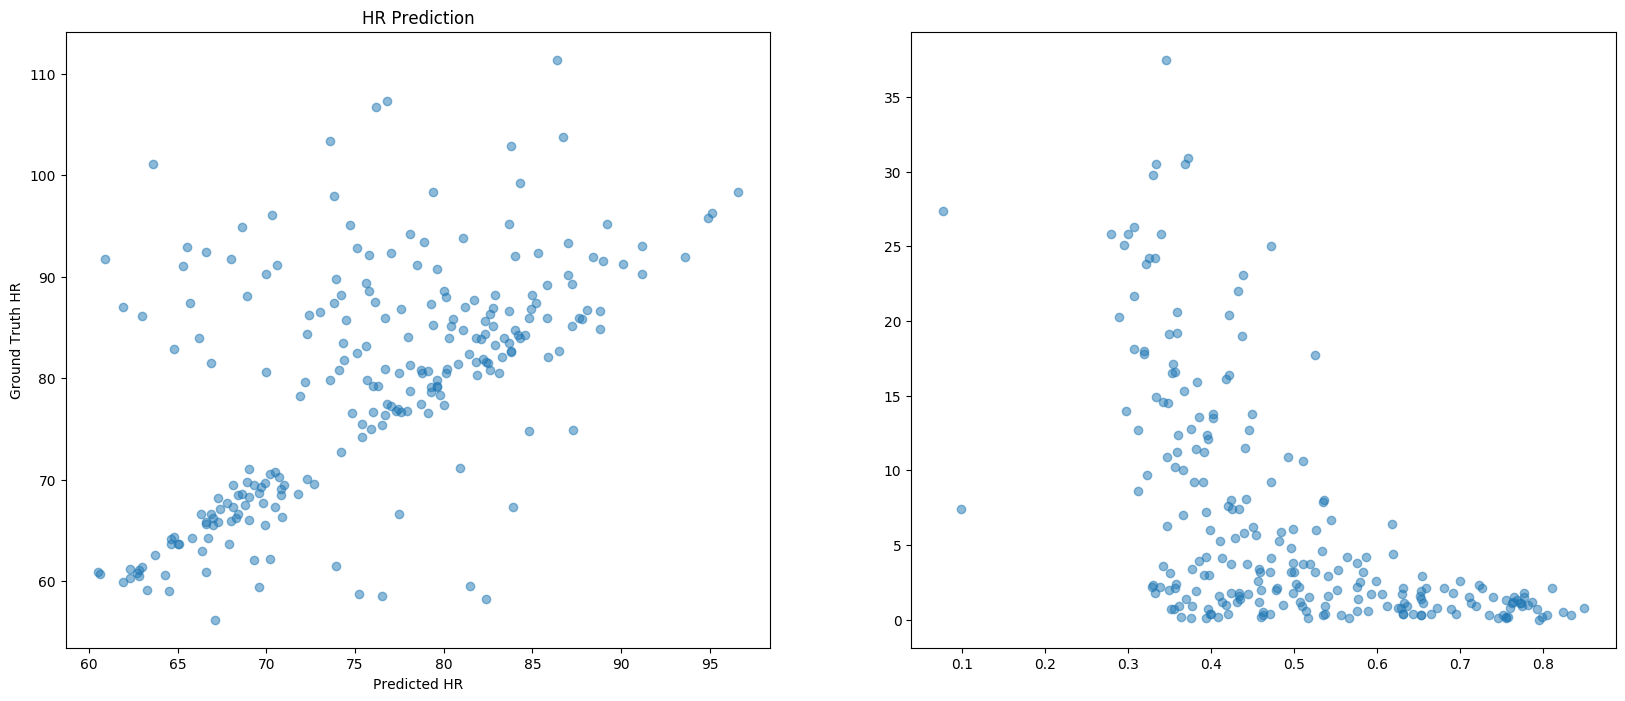

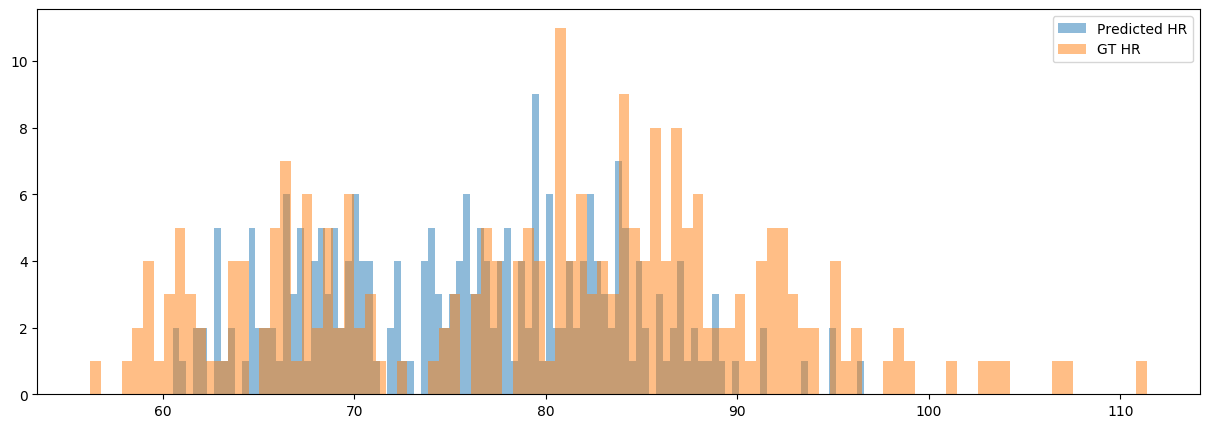

In [40]:
all_errors = np.abs(all_rppg_hr - all_ppg_hr)
print(np.mean(all_errors), np.std(all_errors))
print(np.sum(all_errors < 15), len(all_errors))
print(all_errors[all_errors < 15].mean(), all_errors[all_errors < 15].std())
print(np.sum(all_errors < 5), len(all_errors))
print(all_errors[all_errors < 5].mean(), all_errors[all_errors < 5].std())
print(len(all_errors[all_goodness > 0.4]), len(all_errors))
print(all_errors[all_goodness > 0.4].mean(), all_errors[all_goodness > 0.4].std())
# 1x2 plot
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
# plt.plot([40, 120], [40, 120], 'r--')
plt.plot(all_rppg_hr, all_ppg_hr, 'o', alpha=0.5)
plt.xlabel('Predicted HR')
plt.ylabel('Ground Truth HR')
plt.title('HR Prediction') 
plt.subplot(1, 2, 2)
plt.plot(all_goodness, all_errors, 'o', alpha=0.5)
plt.show()

plt.figure(figsize=(15, 5))
plt.hist(np.array(all_rppg_hr), bins=100, alpha=0.5, label='Predicted HR')
plt.hist(np.array(all_ppg_hr), bins=100, alpha=0.5, label='GT HR')
plt.legend()
plt.show()

In [41]:
# print(len(all_rppg), len(all_ppg), len(all_participant_task_chunk_list))
# save_folder = "waveforms/fusion_pre/"
# os.makedirs(save_folder, exist_ok=True)
# with open(os.path.join(save_folder, "rppg.pickle"), 'wb') as f:
#     pickle.dump({'rppg': all_rppg, 'ppg': all_ppg, 'participant_task_chunk_id_list': all_participant_task_chunk_list}, f)
# with open(os.path.join(save_folder, "rppg.pickle"), 'rb') as f:
#     data = pickle.load(f)
#     rppg = data['rppg']
#     ppg = data['ppg']
#     participant_task_chunk_id_list = data['participant_task_chunk_id_list']
# print(len(rppg), len(ppg), len(participant_task_chunk_id_list))